# Kyle, Joe, Mark: Milestone 4, Deep Network

Our deep network is a CNN based on a Keras website example and trained it using binary-xent with sigmoidal activation for the output layer. We resized all our images to 300x185x3 upon loading them and selected binary crossentropy as our loss function. More details about the model are available later in the document.

We ran into some issues during the training of our model related to the amount of images AWS servers could manage at any given time. With a "p2.xlarge" instance roughly 15,000 images total could be stored in memory (12GB on Tesla K80). We had many more images than this, so we took advantage of being able to run 10 training epochs to train our model 10k images at a time, draw another sample, and train again in an iterative process to improve test performance. We also standardized each image, so that it has a mean of 0 and std of 1.

After 100 epochs of training on a small subset of our data, our model achieved a binary accuracy of 0.9939. As can be seen from the matplotlib visualizations, four out of our seven genres were predicted as almost entirely zero while three predicted genre lables were more accurate. Rather than using overall accuracy, we explored the average Precision and Recall across test observations when tuning parameters for our model. Our main limiting factor for model improvement in this round was time required to test new parameters without "breaking the bank" on AWS credits. We hope to continue improving this model prior to the final paper.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import ndimage

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.image import ImageDataGenerator

from IPython.display import SVG
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load data
%cd ~/data/
labs = pd.read_csv('multilabels.csv')
ids = pd.read_csv('features_V1.csv', usecols=[0])

# Take care of some weirdness that led to duplicate entries
labs = pd.concat([ids,labs], axis=1, ignore_index=True)
labs = labs.drop_duplicates(subset=[0])

ids = labs.pop(0).as_matrix()
labs = labs.as_matrix()

/home/ubuntu/data


In [3]:
# Split train/test - 15k is about the limit of what we can hold in memory (12GB on Tesla K80)
n_train = 10000
n_test = 5000

rnd_ids = np.random.choice(np.squeeze(ids), size=n_train+n_test, replace=False)
train_ids = rnd_ids[:n_train]
test_ids = rnd_ids[n_train:]

# Pull in multilabels
y_train = labs[np.nonzero(np.in1d(np.squeeze(ids),train_ids))[0]]
y_test = labs[np.nonzero(np.in1d(np.squeeze(ids),test_ids))[0]]



# Read in images - need to do some goofy stuff here to handle the highly irregular image sizes and formats
X_train = np.zeros([n_train, 600, 185, 3])
ct = 0
for i in train_ids:
    IM = ndimage.imread('posters/{}.jpg'.format(i))
    try:
        X_train[ct,:IM.shape[0],:,:] = IM[:,:,:3]
    except:
        X_train[ct,:IM.shape[0],:,0] = IM
    ct += 1
    if ct % 100 == 0:
        print 'training data {i}/{n} loaded'.format(i=ct, n=n_train)
X_train = X_train[:,:300,:,:] # trim excess off edges
print 'training data loaded'


X_test = np.zeros([n_test, 600, 185, 3])
ct = 0
for i in test_ids:
    IM = ndimage.imread('posters/{}.jpg'.format(i))
    try:
        X_test[ct,:IM.shape[0],:,:] = IM[:,:,:3]
    except:
        X_test[ct,:IM.shape[0],:,0] = IM
    ct += 1
    if ct % 100 == 0:
        print 'test data {i}/{n} loaded'.format(i=ct, n=n_test)
X_test = X_test[:,:300,:,:] # trim excess off edges
print 'test data loaded'

# Create dataGenerator to feed image batches - 
# this is nice because it also standardizes training data
datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True)


# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

training data 100/10000 loaded
training data 200/10000 loaded
training data 300/10000 loaded
training data 400/10000 loaded
training data 500/10000 loaded
training data 600/10000 loaded
training data 700/10000 loaded
training data 800/10000 loaded
training data 900/10000 loaded
training data 1000/10000 loaded
training data 1100/10000 loaded
training data 1200/10000 loaded
training data 1300/10000 loaded
training data 1400/10000 loaded
training data 1500/10000 loaded
training data 1600/10000 loaded
training data 1700/10000 loaded
training data 1800/10000 loaded
training data 1900/10000 loaded
training data 2000/10000 loaded
training data 2100/10000 loaded
training data 2200/10000 loaded
training data 2300/10000 loaded
training data 2400/10000 loaded
training data 2500/10000 loaded
training data 2600/10000 loaded
training data 2700/10000 loaded
training data 2800/10000 loaded
training data 2900/10000 loaded
training data 3000/10000 loaded
training data 3100/10000 loaded
training data 320

In [52]:
# Build CNN model

model = Sequential()

# input: 300x185 images with 3 channels -> (300, 185, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 185, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='sigmoid'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='binary_crossentropy', optimizer=sgd)



model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['binary_accuracy'])

model.summary()

# Visualize network graph
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 298, 183, 32)      896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 296, 181, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 148, 90, 32)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 148, 90, 32)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 146, 88, 64)       18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 144, 86, 64)       36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 72, 43, 64)        0         
__________

### Model construction

We decided to implement a convolutional neural network that we adapted from the Keras "VGG-like convnet" tutorial.  This is essentially a much simplified version of the pre-trained VGG-16 model that we fine-tuned.

The network consists of a two convolution layers with ReLu activation, followed by max pooling, a repeat of this motif, and then two fully connected layers - the first with ReLU activation and the output layer with sigmoidal activation.  The model is regularized using dropout after each max pool and between the two fully connected layers.

We trained the network using a binary cross-entropy loss function and an RMSprop optimizer.  We tried a number of other optimizers, including SGD w/momentum, Adam, and Nadam - none of which showed much difference in performance and were all slighly slower to learn than RMSprop.

Because we use an RMSProp optimizer we plan to only tune the learning rate for the model as the documentation suggests leaving the other parameters at their defaults. First we test this model on a smaller set (512) images to make sure it works well, then move on to training this model on a set of 10,000 images.

In [11]:
# Fit the model with a small batch of training data, n=512 images
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=100)

score = model.evaluate(X_test, y_test, batch_size=32)

Epoch 1/100
16/16 [==============================] - 7s - loss: 0.9580 - binary_accuracy: 0.7522      

In [15]:
model.predict(X_test[:50,:,:,:])

array([[  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  9.04261395e-26,   9.99990225e-01,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.04094781e-02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   9.97779191e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00,   7.04561935e-26,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  2.42011310e-33,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   2.44924887e-17,   9.84471858e-01,
          0.00000000e+00,   0.00

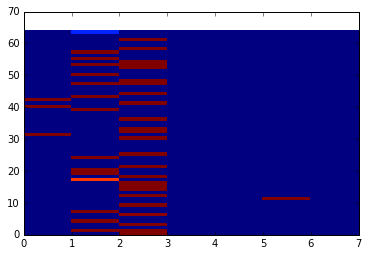

In [25]:
plt.pcolor(model.predict(X_test))

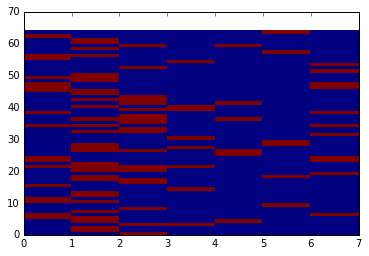

In [26]:
plt.pcolor(y_test)

In [34]:
# Now fit the model using a much bigger training set, n=1e4
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10)


# Now, I think this may be wrong since we're not applying the 
# same input transformation as the data feeder:
score = model.evaluate(X_test, y_test, batch_size=32)


# Maybe the right way to do it looks something like:
#score = model.predict_generator(datagen.flow(X_test, y_test), steps=100)

Epoch 1/10
312/312 [==============================] - 134s - loss: 0.4772 - binary_accuracy: 0.7865     

In [35]:
# Performance on the test set
print score

[2.5414306640625002, 0.76908571910858159]


We can see that the performance on the test set is much worse that, with an overall binary accuracy of 0.77 - much less than the final training set accuracy of 0.89.  It seems that we have not trained the model on a large enough set of images, or we are just overfitting that data we have.  We can try to load a new set of training images and then continue training the model to see if test performance improves.

In [ ]:
# Continue fitting the model for another 5 epochs and see if much changes - we could just be overfitting at this point
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=5)

score = model.evaluate(X_test, y_test, batch_size=32)

Epoch 1/5
312/312 [==============================] - 134s - loss: 0.2249 - binary_accuracy: 0.9064     

In [36]:
#RMSProp optimizer to tune learning rate, others at default as suggested by documentation
# try learning rate of 0.01
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0),
              metrics=['binary_accuracy'])

In [37]:
# Now fit the model using a much bigger training set, n=1e4
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10)

score = model.evaluate(X_test, y_test, batch_size=32)

Epoch 1/10
312/312 [==============================] - 132s - loss: 3.5036 - binary_accuracy: 0.7815     

In [38]:
print score

[3.4490453636169431, 0.78522857685089109]


In [16]:
#RMSProp optimizer to tune learning rate, others at default as suggested by documentation
# try learning rate of 0.0001
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0),
              metrics=['binary_accuracy'])

In [17]:
# Now fit the model using a much bigger training set, n=1e4
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10)

Epoch 1/10
312/312 [==============================] - 132s - loss: 0.3281 - binary_accuracy: 0.8557     

In [18]:
score = model.evaluate(X_test, y_test, batch_size=32)

5000/5000 [==============================] - 23s     

In [19]:
print score

[3.2831739994049074, 0.78471429309844976]


Looking at the results from the models above, one can see that as the number of epochs increases, the binary accuracy improves and the loss decreases. This also improves the score of the model as well. Next, looking at the learning rate, the default LR of 0.001 with the RMSProp optimizer with 10 epochs performs better than when the LR is set to 0.01 as this results in lower loss and higher binary accuracy. When the learning rate is set to 0.0001 the loss and binary accuracy are similar to that of a learning rate of 0.001. For that sake of this analysis we will choose a learning rate of 0.0001, however we may explore even smaller learning rates as we move forward training with more epochs. Now we will train a model with 15 epochs to see how the performance varies. For the sake of time we will not extend beyond this, however we plan to use even more as we progress.

In [53]:
#RMSProp optimizer to tune learning rate, others at default as suggested by documentation
# choose learning rate of 0.001 
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0),
              metrics=['binary_accuracy'])

In [54]:
# Now fit the model using a much bigger training set, n=1e4
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=15)

Epoch 1/15
312/312 [==============================] - 135s - loss: 0.4991 - binary_accuracy: 0.7820     

In [55]:
score = model.evaluate(X_test, y_test, batch_size=32)
print score

5000/5000 [==============================] - 23s     

Based on the above result compared to the previous models it appears that it would be a good idea to test a larger number of epochs (maybe 100) and see if the model performance improves.